# 相关链接

**[Elo Merchant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation)**

In [1]:
import os
import time
import pickle
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import xgboost as xgb
import lightgbm as lgb

from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
data_path = 'F:/git_repos/Kaggle_code/elo-merchant-category-recommendation/data/elo-merchant-category-recommendation/'

train_df = pd.read_csv(data_path + 'train.csv', parse_dates=['first_active_month'])
test_df = pd.read_csv(data_path + 'test.csv', parse_dates=['first_active_month'])
print("Number of rows and columns in train set : ",train_df.shape)
print("Number of rows and columns in test set : ",test_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


In [3]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


### 目标列探索

通过图形可视化展现目标值的分布情况

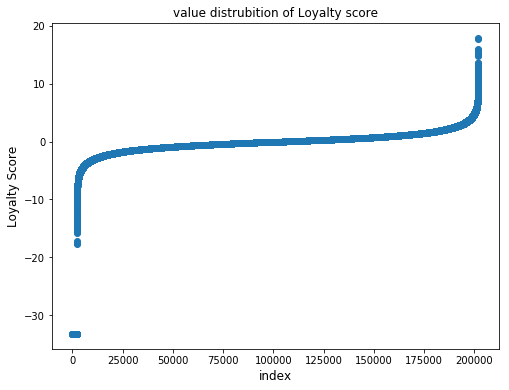

In [9]:
target_col = 'target'

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.title("value distrubition of Loyalty score")
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

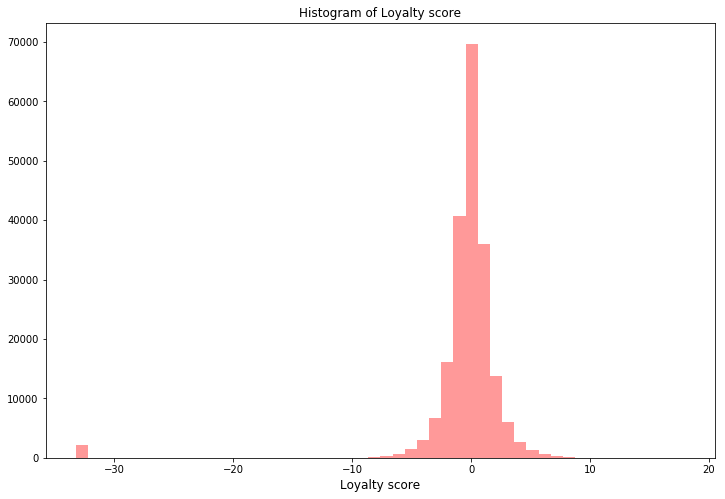

In [17]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

In [6]:
train_df['target'].max(), train_df['target'].min()

(17.9650684, -33.21928095)

In [7]:
train_df.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749
5,2016-09-01,C_ID_0894217f2f,4,2,0,0.871585
6,2016-12-01,C_ID_7e63323c00,3,2,1,0.230129
7,2017-09-01,C_ID_dfa21fc124,3,2,1,2.135850
8,2017-08-01,C_ID_fe0fdac8ea,2,1,0,-0.065406
9,2016-08-01,C_ID_bf62c0b49d,2,2,0,0.300062


In [8]:
test_df.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1
5,2017-07-01,C_ID_5814b4f13c,5,1,1
6,2017-10-01,C_ID_a1b3c75277,1,2,0
7,2017-02-01,C_ID_f7cada36d3,3,1,1
8,2017-07-01,C_ID_9d2bc8dfc4,4,3,0
9,2016-03-01,C_ID_6d8dba8475,5,1,1


In [15]:
(train_df[target_col]<-30).sum()

2207

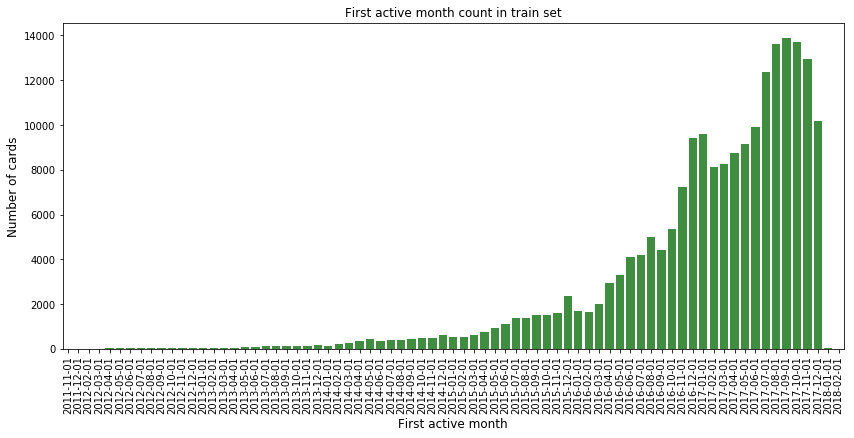

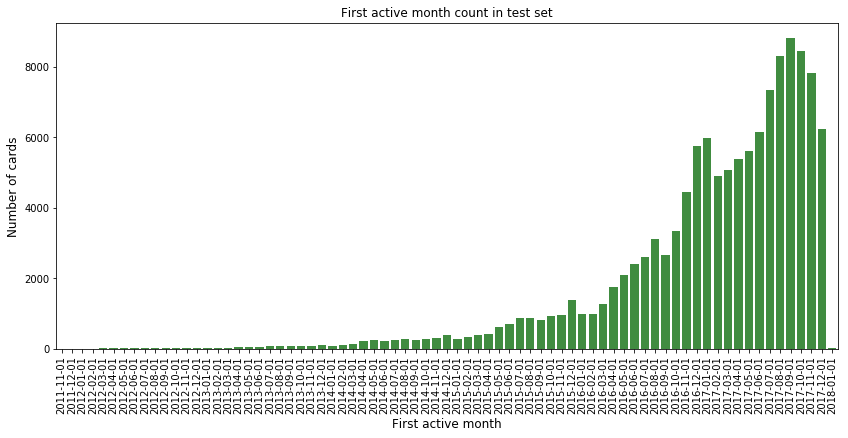

In [16]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

Text(0.5,1,'Feature 3 distribution')

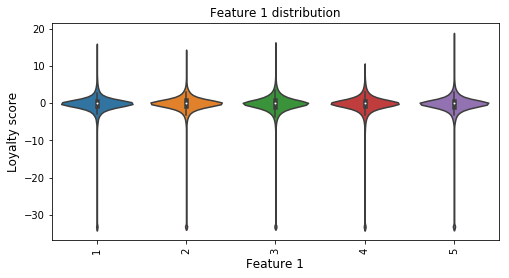

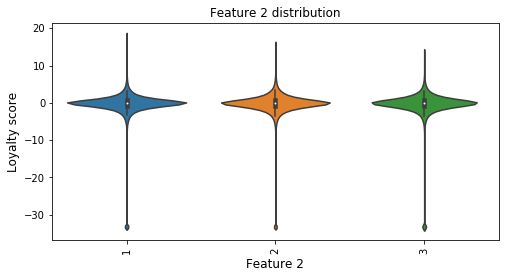

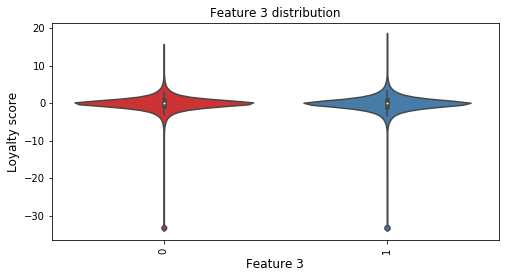

In [22]:
# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
# plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
# plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y=target_col, data=train_df, palette="Set1")
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
# plt.show()

## 历史交易数据分析

In [27]:
hist_df = pd.read_csv(data_path + 'historical_transactions.csv')
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [28]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [30]:
cnt_srs = train_df.groupby("num_hist_transactions")[target_col].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

trace = scatter_plot(cnt_srs, "orange")
layout = dict(
    title='Loyalty score by Number of historical transactions',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Histtranscnt")